In [1]:
; Query the linked data in our triplestore
; to plot some info-graphics.


; Dependencies

(require '[clojupyter.misc.helper :as helper])
(require '[clojupyter.display :as display])

(helper/add-dependencies '[com.datomic/client-pro "0.9.41"])

(require '[clojure.pprint :as pp])
(require '[datomic.client.api :as d])

nil

In [2]:
; Connect to the triplestore (a Datomic database management server)

(def dbms-client
    (d/client { 
        :server-type :peer-server
        :access-key "ash"
        :secret "ash123"
        :endpoint "localhost:8998"
        :validate-hostnames false}))

(def conn (d/connect dbms-client {:db-name "waste"}))
(println conn)

{:db-name waste, :database-id 5e971c8d-9cea-4b08-b05a-3852aecd482b, :t 24323, :next-t 24580, :type :datomic.client/conn}


nil

In [3]:
; Query for the waste tonnage genearated per council citizen per year

(def db (d/db conn))

(def answer
    (d/q '[:find ?c ?y ?t2 :where                       ; return council, year & tonnage
            [?e1 :waste-type/name "Subtotal"]            
            [?e2 :waste-process/name "Generated"]       
            [?e3 :waste-tonnes-cytp/waste-type ?e1]     ; fixed at Subtotal
            [?e3 :waste-tonnes-cytp/waste-process ?e2]  ; fixed at Generated
            [?e3 :waste-tonnes-cytp/tonnes ?t1]         ; tonnage for a council for a year
            [?e3 :waste-tonnes-cytp/council ?e4]
            [?e3 :waste-tonnes-cytp/year ?e5]
            [?e4 :council/name ?c]                      ; used to join waste- & population- facts
            [?e5 :year/value ?y]                        ; used to join waste- & population- facts
            [?e6 :population-cy/council ?e4]
            [?e6 :population-cy/year ?e5]
            [?e6 :population-cy/population ?p]          ; population for a council for a year 
            [(/ ?t1 ?p) ?t2]]                           ; calculate the tonnage per citizen
             db))

; For plotting, convert tuples->maps
(def ks [:council :year :tonnage])
(def answer' (->> answer 
                  (map #(zipmap ks %))
                  (map #(assoc % :year (str (:year %))))))

; Print a sample
(pp/print-table ks (repeatedly 5 #(rand-nth answer')))


|          :council | :year |            :tonnage |
|-------------------+-------+---------------------|
| East Renfrewshire |  2016 |  0.5087279607717727 |
|  Scottish Borders |  2014 | 0.43802209750964577 |
| East Renfrewshire |  2018 | 0.46156866659661655 |
|  Clackmannanshire |  2015 |  0.5183232087227415 |
|    Orkney Islands |  2018 | 0.46059125732311856 |


nil

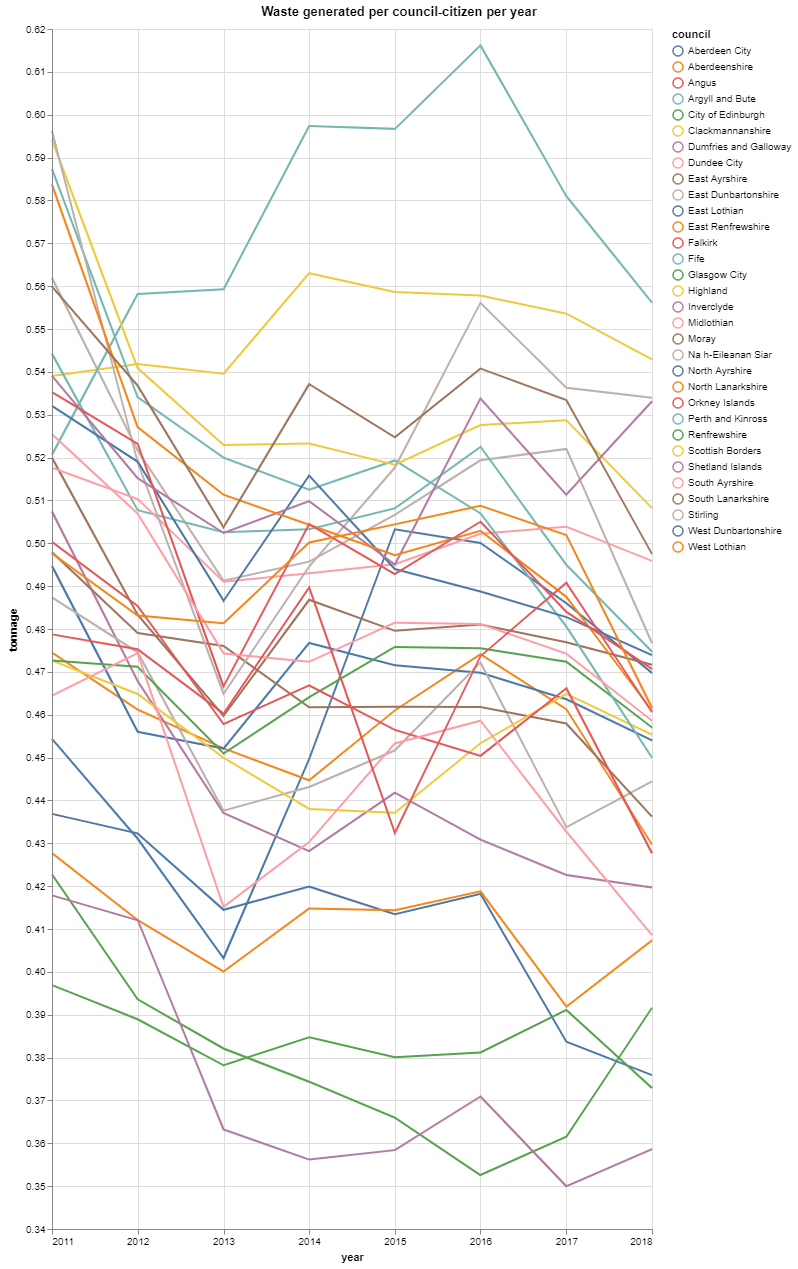

In [4]:
; Plot an info-graphic the waste tonnage genearated per council citizen per year

(defn line-graph [title data]
  (let [year-count (count (group-by :year data))]
    {:title title
     :width 600
     :height 1200       
     :data {:values data}
     :mark "line"
     :layer [
             {
              :encoding {
                         :x {:field "year" :type "temporal" :timeUnit "year" :axis {:tickCount year-count :title "year"}}
                         :y {:field "tonnage" :type "quantitative" :scale {:zero false} :axis {:title "tonnage"}}
                         :color {:field "council" :type "nominal"}}
              :layer [
                      {:mark "line"}
                      {
                       :selection {
                                   :label {
                                           :type "single"
                                           :nearest true
                                           :on "mouseover"
                                           :encodings ["x"]
                                           :empty "none"
                                           }
                                   }
                       :mark "point"
                       :encoding {
                                  :opacity {
                                            :condition {:selection "label" :value 1}
                                            :value 0
                                            }
                                  }
                       }
                      ]
              }
             {
      :transform [{:filter {:selection "label"}}],
      :layer [
        {
          :mark {:type "rule" :color "gray"},
          :encoding {
            :x {:type "temporal"  :field "year"}
          }
        },
        {
          :encoding {
            :text {:type "nominal", :field "council"},
            :x {:type "temporal", :field "year"},
            :y {:type "quantitative", :field "tonnage"}
          },
          :layer [
            {
              :mark {
                :type "text",
                :stroke "white",
                :strokeWidth 2,
                :align "left",
                :dx 5,
                :dy -5
              }
            },
            {
              :mark {:type "text", :align "left", :dx 5, :dy -5},
              :encoding {
                :color {:type "nominal", :field "council"}
              }
            }
          ]
        }
      ]
    }
             ]
     }))

(display/render-mime 
    :application/vnd.vegalite.v2+json 
    (line-graph "Waste generated per council-citizen per year" answer'))

In [5]:
; Query for the waste tonnage genearated vs recycled per Stirling council citizen per year

(def answer
    (d/q '[:find ?y ?p ?t :where
            [?e1 :council/name "Stirling"]
            [?e2 :waste-type/name "Subtotal"]
            [?e3 :waste-tonnes-cytp/council ?e1]
            [?e3 :waste-tonnes-cytp/waste-type ?e2]
            [?e3 :waste-tonnes-cytp/waste-process ?e4]
            [?e3 :waste-tonnes-cytp/year ?e5]
            [?e3 :waste-tonnes-cytp/tonnes ?t]
            [?e4 :waste-process/name ?p]
            (or-join [?e4 ?p]
                     [?e4 :waste-process/name "Generated"]
                     [?e4 :waste-process/name "Recycled"])
            [?e5 :year/value ?y]]
             db))

; For plotting, convert tuples->maps
(def ks [:year :process :tonnage])
(def answer' (->> answer 
                  (map #(zipmap ks %))
                  (map #(assoc % :year (str (:year %))))))

; Print a sample
(pp/print-table ks (repeatedly 5 #(rand-nth answer')))


| :year |  :process | :tonnage |
|-------+-----------+----------|
|  2017 |  Recycled | 12158.45 |
|  2012 | Generated |  43190.1 |
|  2016 |  Recycled | 11481.16 |
|  2016 | Generated | 44270.58 |
|  2018 | Generated | 41925.04 |


nil

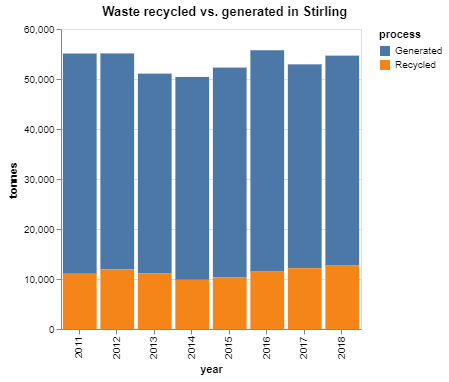

In [6]:
; Plot an info-graphic the waste tonnage genearated vs recycled per year in Stirling

(defn stacked-bar-chart [title data]
    (let [year-count (count (group-by :year data))]
  {:title title
   :width 300
   :height 300       
   :data {:values data}
   :mark {:type "bar" :cornerRadiusTopLeft 3 :cornerRadiusTopRight 3}
   :encoding {
            :x {:field "year" :type "nominal" :title "year"}
            :y {:field "tonnage" :type "quantitative" :scale {:zero false} :axis {:title "tonnes"}}
            :color {:field "process" :type "nominal"}}}))

(display/render-mime 
    :application/vnd.vegalite.v2+json 
    (stacked-bar-chart "Waste recycled vs. generated in Stirling" answer'))